# Samples analysis
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/sample_analysis.ipynb)

Analyse cosmological model posterior samples.

In [ ]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.75' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path
from getdist import plots
import jax

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

# save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/lpt_64_fnl_0")
save_dir = Path("/pscratch/sd/h/hsimfroy/png/lpt_32_fnl_0_lc_apauto_nodec")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
nid001052


/global/u1/h/hsimfroy/miniforge3/envs/montenv/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Example 1: assess MCMC convergence

In [2]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme, SetDark2
theme(usetex=False, font_size=12)

model = FieldLevelModel.load(save_dir / "model.yaml")
truth = dict(jnp.load(save_dir / 'truth.npz'))
mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
delta_obs = model.count2delta(truth['obs'])
kptc_obs = model.powtranscoh(mesh_true, delta_obs)

obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','fNL','ngbar','init_mesh']
obs = {k: truth[k] for k in obs}
model.condition(obs, from_base=True)

chains = pload(save_path + "_chains.p")
# chains_ = pload(save_path + "_chains_.p")
chains = chains[:,100:]
chains_mesh = pload(save_path + "_chains_mesh.p")
print(chains.shape)
print(chains_mesh.shape)
names = ['cosmo','bias','syst','init']

{'Omega_m': (6, 1692), 'b1': (6, 1692), 'b2': (6, 1692), 'bn2': (6, 1692), 'bs2': (6, 1692), 'fNL': (6, 1692), 'init_mesh': (6, 1692, 10), 'kptc': ((6, 1692, 6), (6, 1692, 6), (6, 1692, 6), (6, 1692, 6)), 'logdensity': (6, 1692), 'mse_per_dim': (6, 1692), 'n_evals': (6, 1692), 'ngbar': (6, 1692), 'sigma8': (6, 1692)}
{'Omega_m': (6, 28), 'b1': (6, 28), 'b2': (6, 28), 'bn2': (6, 28), 'bs2': (6, 28), 'fNL': (6, 28), 'init_mesh': (6, 28, 26, 50, 26), 'kptc': ((6, 28, 6), (6, 28, 6), (6, 28, 6), (6, 28, 6)), 'logdensity': (6, 28), 'mse_per_dim': (6, 28), 'n_evals': (6, 28), 'ngbar': (6, 28), 'sigma8': (6, 28)}


### Inspecting chains
We look for mixed chains (no visible trends), `n_eff`>500, `r_hat`<1.01

ss:  [6.78924391 6.78924391 6.78924391 6.78924391 6.78924391 6.78924391]
L:  [1357.84878154 1357.84878154 1357.84878154 1357.84878154 1357.84878154
 1357.84878154]
inv_mm: {'Omega_m_': Array(0.0006394, dtype=float64), 'b1_': Array(5.44848468, dtype=float64), 'b2_': Array(4.4461007, dtype=float64), 'bn2_': Array(5.38321738, dtype=float64), 'bs2_': Array(2.44443176, dtype=float64), 'fNL_': Array(0.27611785, dtype=float64), 'init_mesh_': Array([[[ 0.95914779,  2.8516507 ,  7.80620746, ...,  5.98492791,
          4.55956078,  8.66538399],
        [ 3.0938744 ,  5.56638262,  4.3999433 , ...,  9.61870029,
          1.8274866 ,  7.00666654],
        [ 3.87568491,  2.86208341,  4.79680295, ...,  4.77257963,
          5.82200858,  6.41824638],
        ...,
        [ 3.94490587,  3.98517482,  4.04302168, ...,  6.5013308 ,
          2.60885231, 12.35491118],
        [10.0560566 ,  1.03758573,  1.96861225, ...,  5.3983897 ,
          2.31444796,  3.16842053],
        [ 6.35160718,  3.52431083,  4.

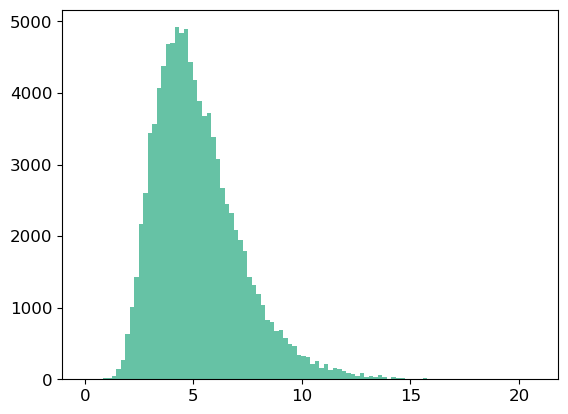

In [3]:
config = pload(save_path+"_conf.p")
state = pload(save_path+"_last_state.p")

print("ss: ", config.step_size)
print("L: ", config.L)
from jax.flatten_util import ravel_pytree
flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))

# plt.hist(chains['init_mesh'].std((0,1)), bins=50);
plt.hist(np.random.choice(config.inverse_mass_matrix[0], 100_000), bins=100);


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           b2      0.14      1.00      0.12     -1.58      1.72   1141.15      1.00
  mse_per_dim      0.00      0.00      0.00      0.00      0.00   4355.70      1.00
      n_evals    128.00      0.00    128.00    128.00    128.00       nan       nan
 init_mesh[0]      0.00      0.13     -0.00     -0.21      0.21   4634.57      1.00
 init_mesh[1]     -0.00      0.13      0.00     -0.21      0.20   4704.89      1.00
 init_mesh[2]     -0.00      0.13     -0.00     -0.21      0.20   4659.04      1.00
 init_mesh[3]      0.01      0.13      0.01     -0.22      0.20   4692.35      1.00
 init_mesh[4]     -0.00      0.13     -0.00     -0.22      0.19   4664.78      1.00
 init_mesh[5]      0.00      0.13      0.00     -0.20      0.22   4665.60      1.00
 init_mesh[6]     -0.00      0.12      0.00     -0.20      0.20   4686.23      1.00
 init_mesh[7]      0.01      0.13      0.01     -0.20      0.23   4639.72  

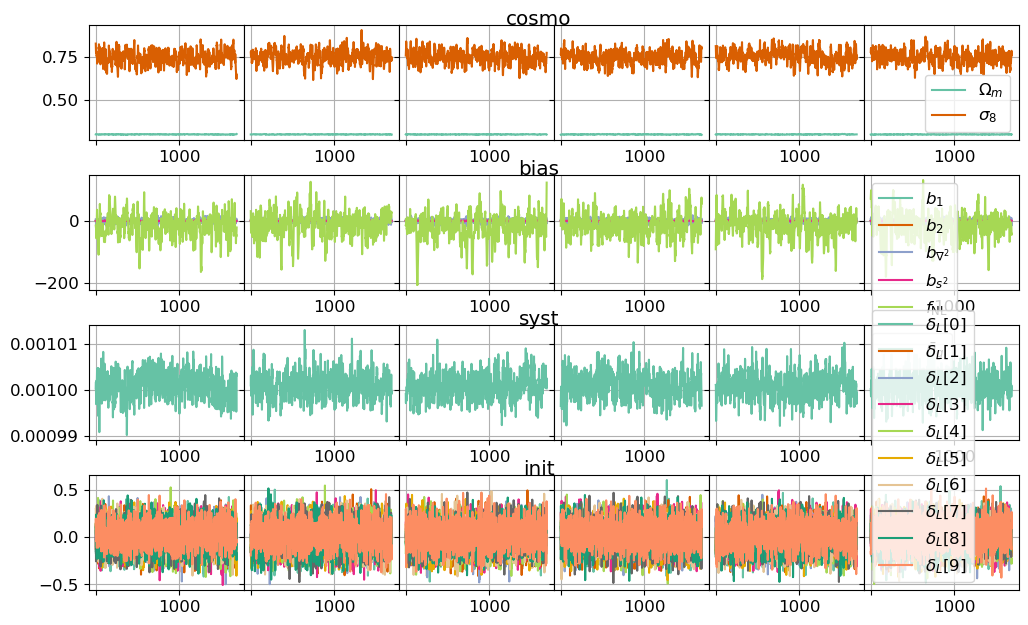

In [4]:
plt.figure(figsize=(12,6))
chains[['*~kptc']].flatten().plot(names)
chains[['*~kptc']].print_summary()

Removed no burn in


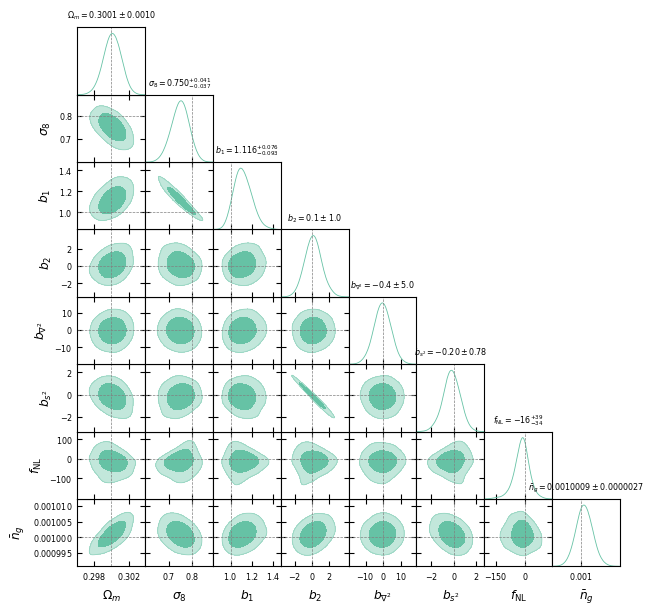

In [7]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


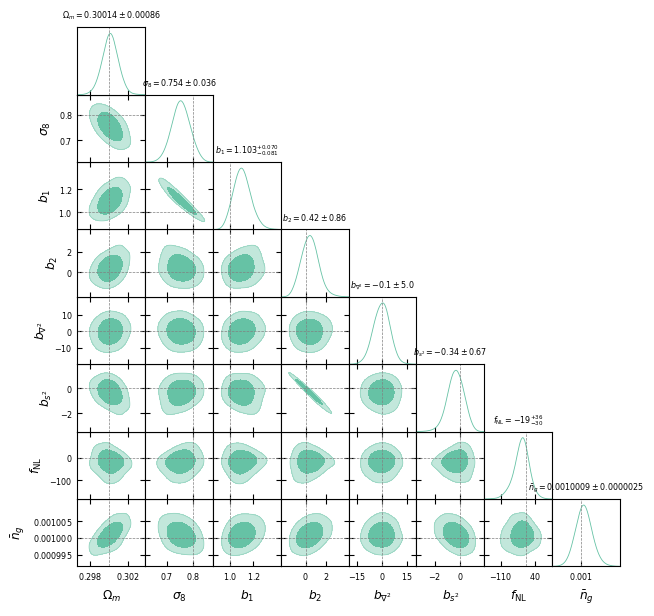

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

Removed no burn in


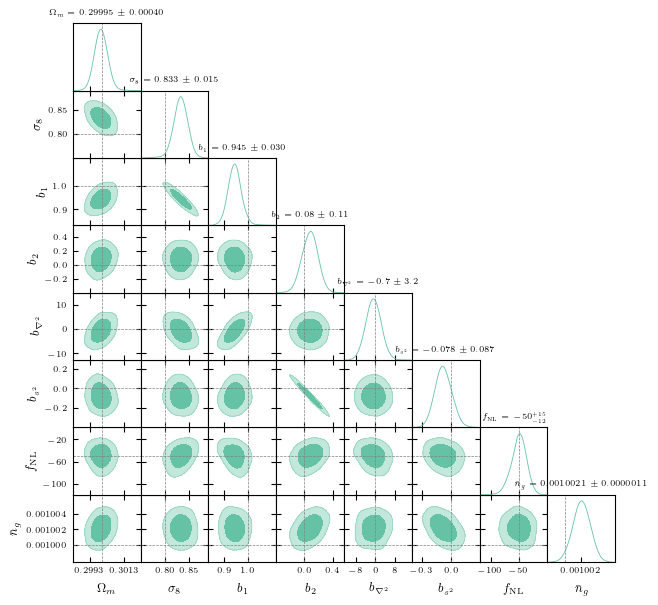

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

### Inspection at the field-Level
Power spectrum should converge close to the truth, and coherence must be on the order of the coherence between truth and obs

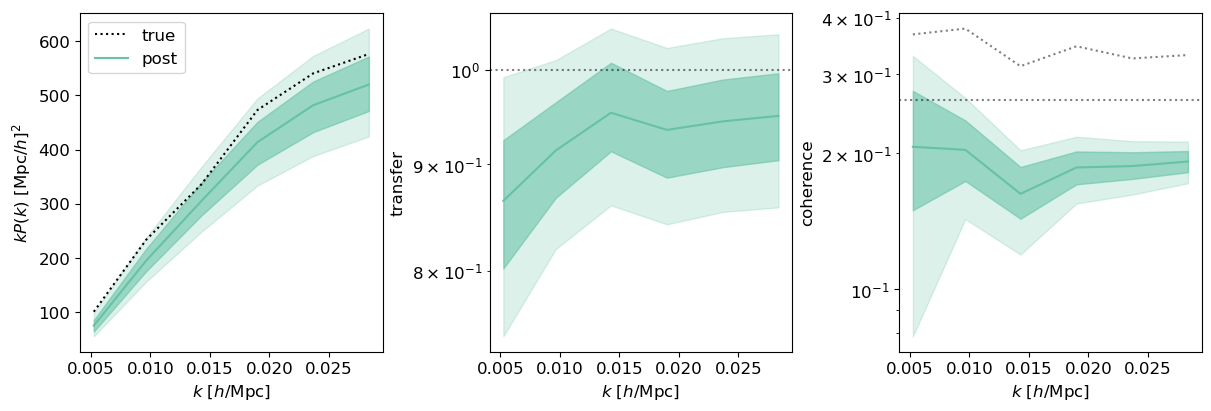

In [15]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme, SetDark2

prob = 0.95
plt.figure(figsize=(12, 4), layout='constrained')
def plot_kptcs(kptcs, label=None):
    plot_powtranscoh(*kptcs, fill=0.68, color=SetDark2(0))
    plot_powtranscoh(*kptcs, fill=0.95, color=SetDark2(0))
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs), label=label)

plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='true')
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(model.wind_mesh.mean(), linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_obs[0], kptc_obs[3], 'k:', alpha=0.5, label='obs')

kptcs = tree.map(jnp.concatenate, chains['kptc'])
plot_kptcs(kptcs, label='post')
plt.subplot(131)
plt.legend();
# plt.savefig(f'init_warm.png')   

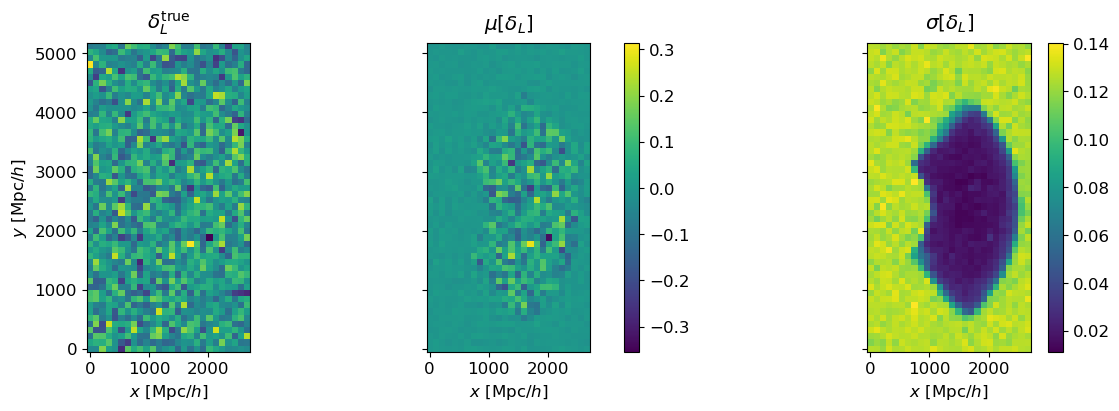

In [16]:
from montecosmo.plot import plot_mesh

axis = 2
ind = .1
meshes = jnp.concatenate(chains_mesh['init'])

plt.figure(figsize=(12, 4), layout='constrained')
ax1 = plt.subplot(131)
plt.title('$\\delta_L^\\mathrm{true}$', pad=10)
quad1 = plot_mesh(mesh_true, model.box_shape, ind, axis)
clim = quad1.get_clim()

ax2 = plt.subplot(132, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.title('$\\mu[\\delta_L]$', pad=10)
plot_mesh(meshes.mean(0), model.box_shape, ind, axis, vlim=clim)
plt.ylabel(None)
plt.colorbar(ax=np.array([ax1, ax2]))

ax3 = plt.subplot(133)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.title('$\\sigma[\\delta_L]$', pad=10)
plot_mesh(meshes.std(0), model.box_shape, ind, axis)
plt.ylabel(None)
plt.colorbar();

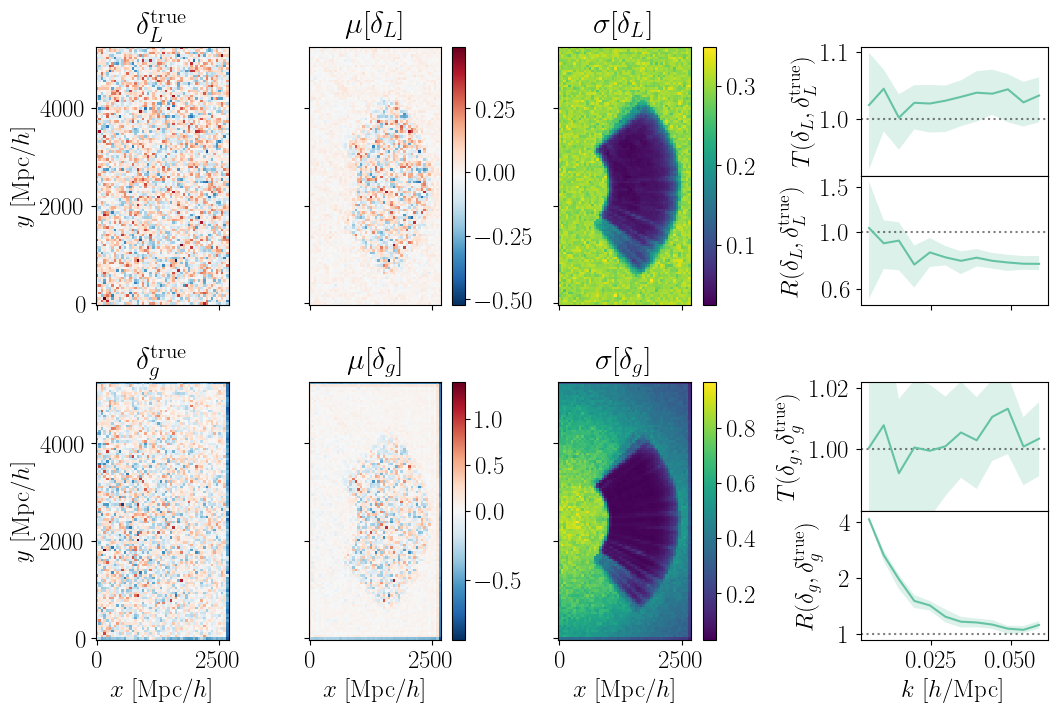

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, plot_mesh, theme, SetDark2
theme(usetex=True, font_size=18)

chpost = jnp.load("post.npz")
chpopred = jnp.load("postpred.npz")

def scalarformatter(n):
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    if isinstance(n, int):
        plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(n))
    else:
        plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator([]))
        

# Create a figure
# fig = plt.figure(figsize=(18, 7.7))
fig = plt.figure(figsize=(14, 7.7))

gs14 = GridSpec(2, 4, figure=fig, wspace=0.6, hspace=0.3)
gs21_14 = gs14[0, 3].subgridspec(2, 1, hspace=0)
gs21_24 = gs14[1, 3].subgridspec(2, 1, hspace=0)

gs12_11 = gs14[0, 0:3].subgridspec(1, 3, wspace=-0.2)
gs12_21 = gs14[1, 0:3].subgridspec(1, 3, wspace=-0.2)

# Add subplots to the inner grid
ax141 = fig.add_subplot(gs21_14[0])
ax142 = fig.add_subplot(gs21_14[1], sharex=ax141)
plt.setp(ax141.get_xticklabels(), visible=False)
plt.setp(ax142.get_xticklabels(), visible=False)


ax241 = fig.add_subplot(gs21_24[0])
ax242 = fig.add_subplot(gs21_24[1], sharex=ax241)
plt.setp(ax241.get_xticklabels(), visible=False)

ax11 = fig.add_subplot(gs12_11[0])
plt.setp(ax11.get_xticklabels(), visible=False)
ax12 = fig.add_subplot(gs12_11[1], sharey=ax11)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
# ax112.set_yticks([])
ax13 = fig.add_subplot(gs12_11[2], sharey=ax11)
plt.setp(ax13.get_yticklabels(), visible=False)
plt.setp(ax13.get_xticklabels(), visible=False)

ax21 = fig.add_subplot(gs12_21[0])
ax22 = fig.add_subplot(gs12_21[1], sharey=ax21)
plt.setp(ax22.get_yticklabels(), visible=False)
ax23 = fig.add_subplot(gs12_21[2], sharey=ax21)
plt.setp(ax23.get_yticklabels(), visible=False)




# Linear matter field
ids = 0.1
log = False
prob = 0.95
cmap = 'viridis'
cmap2 = 'RdBu_r'
axis = 2
transpose = False
meshes = jnp.concatenate(chpost['init_mesh'])

plt.sca(ax11)
quad11 = plot_mesh(mesh_true, model.box_shape, ids, axis, transpose=transpose, cmap=cmap2)
# plt.colorbar()
plt.xlabel(None)
plt.title('$ \\delta_L^\\mathrm{true}$', pad=10)
clim = quad11.get_clim()

plt.sca(ax12)
plot_mesh(meshes.mean(0), model.box_shape, ids, axis, vlim=clim, transpose=transpose, cmap=cmap2)
plt.ylabel(None)
# plt.yticks([])
plt.xlabel(None)
plt.title('$\\mu[\\delta_L]$', pad=10)
plt.colorbar(ax=np.array([ax11, ax12]), pad=0.02, fraction=0.1)

plt.sca(ax13)
plot_mesh(meshes.std(0), model.box_shape, ids, axis, transpose=transpose, cmap=cmap)
plt.ylabel(None)
plt.xlabel(None)
plt.colorbar(pad=0.04)
plt.title('$\\sigma[\\delta_L]$', pad=10)

plt.sca(ax141)
kptcs = tree.map(jnp.concatenate, tuple(chpost['kptc']))
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')
plt.xlabel(None)
scalarformatter(2)

plt.sca(ax142)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$', labelpad=12)
# scalarformatter([1.0, 0.5, 0.1])
scalarformatter([1.5, 1.0, 0.6])
plt.xlabel(None)


# Galaxy density field
ids = 0.1
log = False
prob = 0.95
# meshes = jnp.concatenate(model.count2delta(chpopred['obs']))
meshes = jnp.concatenate(chpopred['gxy_mesh'])-1

lim = 5
# vmin = 0.4
# means = jnp.maximum(meshes, vmin).mean(0)
means = meshes.mean(0)
vmax = np.quantile(means, 1-1e-4/2)

plt.sca(ax21)
quad21 = plot_mesh(truth['gxy_mesh']-1, model.box_shape, ids, axis, vlim=None, transpose=transpose, cmap=cmap2)
clim = quad21.get_clim()
norm = colors.TwoSlopeNorm(0., *clim)
quad21 = plot_mesh(truth['gxy_mesh']-1, model.box_shape, ids, axis, vlim=None, transpose=transpose, cmap=cmap2, norm=norm)
# quad21 = plot_mesh(jnp.maximum(delta_obs, vmin), model.box_shape, ids, axis, vlim=(vmin,vmax), transpose=True, cmap=cmap)
plt.title('$\\delta_g^\\mathrm{true}$', pad=10)

plt.sca(ax22)
plot_mesh(means, model.box_shape, ids, axis, vlim=None, transpose=transpose, cmap=cmap2, norm=norm)
plt.ylabel(None)
# plt.yticks([])
plt.title('$\\mu[\\delta_g]$', pad=10)
from matplotlib import colors
plt.colorbar(ax=np.array([ax21, ax22]), pad=0.02, fraction=0.1)

plt.sca(ax23)
plot_mesh(meshes.std(0), model.box_shape, ids, axis, transpose=transpose, cmap=cmap)
plt.ylabel(None)
plt.colorbar(pad=0.04)
plt.title('$\\sigma[\\delta_g]$', pad=10)

plt.sca(ax241)
kptcs = tree.map(jnp.concatenate, tuple(chpopred['kptc']))
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.xlabel(None)
plt.ylim(0.98, 1.022)
scalarformatter([1.0, 1.02])

plt.sca(ax242)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', labelpad=12)
# ax242.yaxis.set_label_position("right")
# ax242.set_ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', rotation=270, labelpad=20)
# scalarformatter([1.0, 0.8, 0.4])
scalarformatter([4., 2., 1.])

plt.savefig('postfields_fnl_p50.png', dpi=500, bbox_inches='tight')
plt.show()

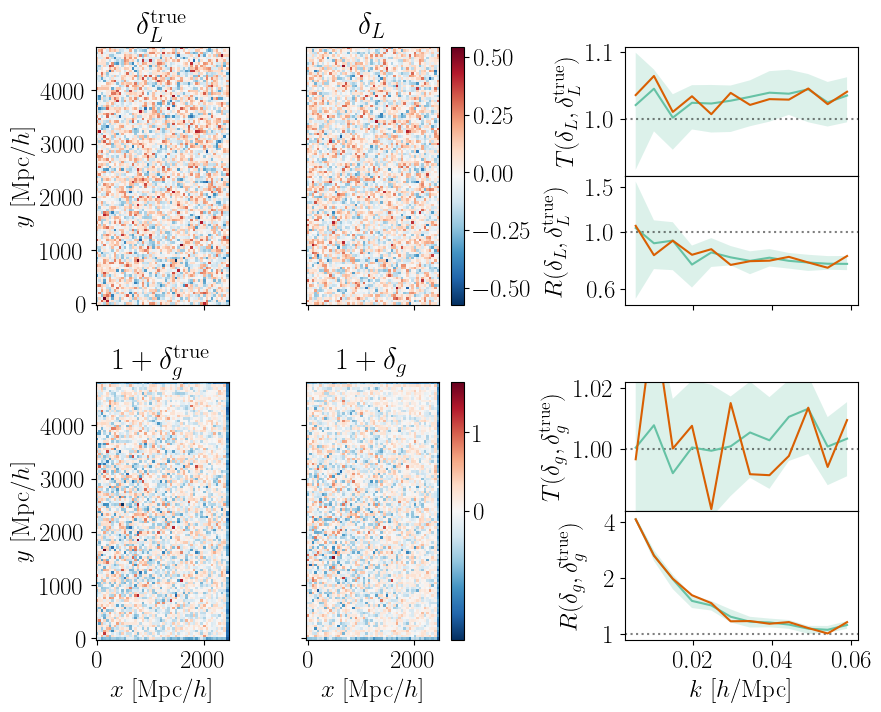

In [151]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from montecosmo.plot import plot_mesh, mean_proj
theme(dark=False, usetex=True, font_size=18, cmap="SetDark2")

chpost = jnp.load("post.npz")
chpopred = jnp.load("postpred.npz")

def scalarformatter(n):
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    if isinstance(n, int):
        plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(n))
    else:
        plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator([]))
        
 
# Create a figure
i_plt = 0
fig = plt.figure(figsize=(12, 7.7))

gs23 = GridSpec(2, 3, figure=fig, wspace=0.5, hspace=0.3)
gs21_13 = gs23[0, 2].subgridspec(2, 1, hspace=0)
gs21_23 = gs23[1, 2].subgridspec(2, 1, hspace=0)

gs12_11 = gs23[0, 0:2].subgridspec(1, 2, wspace=-0.3)
gs12_21 = gs23[1, 0:2].subgridspec(1, 2, wspace=-0.3)

# Add subplots to the inner grid
ax131 = fig.add_subplot(gs21_13[0])
ax132 = fig.add_subplot(gs21_13[1], sharex=ax131)
plt.setp(ax131.get_xticklabels(), visible=False)
plt.setp(ax132.get_xticklabels(), visible=False)

ax231 = fig.add_subplot(gs21_23[0])
ax232 = fig.add_subplot(gs21_23[1], sharex=ax231)
plt.setp(ax231.get_xticklabels(), visible=False)


ax11 = fig.add_subplot(gs12_11[0])
plt.setp(ax11.get_xticklabels(), visible=False)
ax12 = fig.add_subplot(gs12_11[1], sharey=ax11)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
# ax112.set_yticks([])

ax21 = fig.add_subplot(gs12_21[0])
ax22 = fig.add_subplot(gs12_21[1], sharey=ax21)
plt.setp(ax22.get_yticklabels(), visible=False)




# Linear matter field
ids = 0.1
log = False
prob = 0.95
cmap = 'viridis'
cmap2 = 'RdBu_r'
axis = -1
transpose = False
meshes1 = jnp.concatenate(chpost['init_mesh'])
alpha = (1-prob)**.5
# alpha = 0.5



plt.sca(ax11)
quad11 = plot_mesh(mesh_true, model.box_shape, ids, axis, transpose=transpose, cmap=cmap2)
# plt.colorbar()
plt.xlabel(None)
plt.title('$ \\delta_L^\\mathrm{true}$', pad=10)
clim = quad11.get_clim()

plt.sca(ax12)
means = meshes1[i_plt]
quad12 = plot_mesh(means, model.box_shape, ids, axis, vlim=clim, transpose=transpose, cmap=cmap2)
plt.ylabel(None)
# plt.yticks([])
plt.xlabel(None)
plt.title('$\\delta_L$', pad=10)
plt.colorbar(ax=np.array([ax11, ax12]), pad=0.02, fraction=0.1)


plt.sca(ax131)
kptcs1 = tree.map(jnp.concatenate, tuple(chpost['kptc']))
kptc_med1 = tree.map(lambda x: jnp.median(x, 0), kptcs1)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med1[0], kptc_med1[2])
plot_trans(kptcs1[0], kptcs1[2], fill=prob, alpha=alpha)
line131, = plot_trans(kptcs1[0][i_plt], kptcs1[2][i_plt])
plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')
plt.xlabel(None)
scalarformatter(2)

plt.sca(ax132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med1[0], kptc_med1[3])
plot_coh(kptcs1[0], kptcs1[3], fill=prob, alpha=alpha)
line132, = plot_trans(kptcs1[0][i_plt], kptcs1[3][i_plt])
plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$', labelpad=12)
# scalarformatter([1.0, 0.5, 0.1])
scalarformatter([1.5, 1.0, 0.6])
plt.xlabel(None)


# Galaxy density field
sli = 1
log = False
prob = 0.95
# meshes2 = jnp.concatenate(model.count2delta(chpopred['obs']))
meshes2 = jnp.concatenate(chpopred['gxy_mesh'])-1

# vmin = 0.3
# meshes2 = jnp.maximum(meshes2, vmin)
# means = meshes2[...,None]
# vmax = np.quantile(means, [1-1e-4/2])
means = meshes2[i_plt]

plt.sca(ax21)
quad21 = plot_mesh(truth['gxy_mesh']-1, model.box_shape, ids, axis, vlim=None, transpose=transpose, cmap=cmap2)
clim = quad21.get_clim()
norm = colors.TwoSlopeNorm(0., *clim)
quad21 = plot_mesh(truth['gxy_mesh']-1, model.box_shape, ids, axis, vlim=None, transpose=transpose, cmap=cmap2, norm=norm)
# plt.colorbar()
plt.title('$1+ \\delta_g^\\mathrm{true}$', pad=10)

plt.sca(ax22)
quad22 = plot_mesh(means, model.box_shape, ids, axis, vlim=None, transpose=transpose, cmap=cmap2, norm=norm)
plt.ylabel(None)
# plt.yticks([])
plt.title('$1+\\delta_g$', pad=10)
plt.colorbar(ax=np.array([ax21, ax22]), pad=0.02, fraction=0.1)

plt.sca(ax231)
kptcs2 = tree.map(jnp.concatenate, tuple(chpopred['kptc']))
kptc_med2 = tree.map(lambda x: jnp.median(x, 0), kptcs2)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med2[0], kptc_med2[2])
plot_trans(kptcs2[0], kptcs2[2], fill=prob, alpha=alpha)
line231, = plot_trans(kptcs2[0][i_plt], kptcs2[2][i_plt])
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.xlabel(None)
plt.ylim(0.98, 1.022)
scalarformatter([1.0, 1.02])

plt.sca(ax232)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med2[0], kptc_med2[3])
plot_coh(kptcs2[0], kptcs2[3], fill=prob, alpha=alpha)
line232, = plot_trans(kptcs2[0][i_plt], kptcs2[3][i_plt])
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', labelpad=12)
# ax242.yaxis.set_label_position("right")
# ax242.set_ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', rotation=270, labelpad=20)
scalarformatter([4., 2., 1.])

# plt.savefig('post_fields4.png', dpi=500, bbox_inches='tight')
# plt.show()


thinning = 1
def update(i):
    quad12.set_array(mean_proj(meshes1, ids, axis)[::thinning][i])
    quad22.set_array(mean_proj(meshes2, ids, axis)[::thinning][i])

    kptc = tree.map(lambda x: x[::2*thinning][i], kptcs1)
    ks, pow, trans, coh = kptc
    line131.set_data(ks, trans)
    line132.set_data(ks, coh)

    kptc = tree.map(lambda x: x[::thinning][i], kptcs2)
    ks, pow, trans, coh = kptc
    line231.set_data(ks, trans)
    line232.set_data(ks, coh)
  
    return quad12, quad22, line131, line132, line231, line232


display(plt.gcf())
anim = FuncAnimation(plt.gcf(), update, frames=30, interval=100, blit=True)
# anim.save("chains.mp4", dpi=300)
# anim.save("chains.gif", dpi=300)
display(anim)
plt.close()

In [87]:
from montecosmo.bricks import add_png, get_cosmology 
# init['init_mesh'] = vmap(lambda x: add_png(get_cosmology(**truth), truth['fNL'], x, model.mesh_shape, model.box_shape))()
init_nl = (lambda x: jnp.fft.irfftn(add_png(get_cosmology(**truth), truth['fNL'], x, model.mesh_shape, model.box_shape)))(truth['init_mesh'])

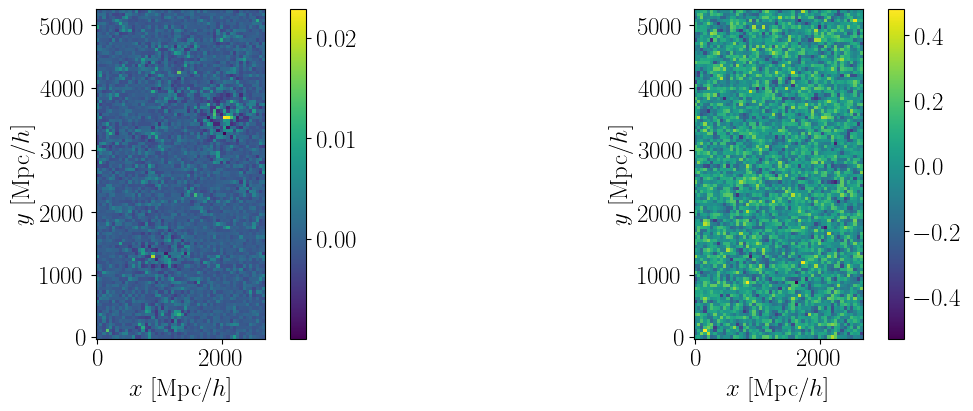

In [104]:
plt.figure(figsize=(12, 4), layout='constrained')
plt.subplot(121)
plot_mesh(mesh_true-init_nl, model.box_shape, 0.1, 2)
plt.colorbar()
plt.subplot(122)
plot_mesh(init_nl, model.box_shape, 0.1, 2)
plt.colorbar()

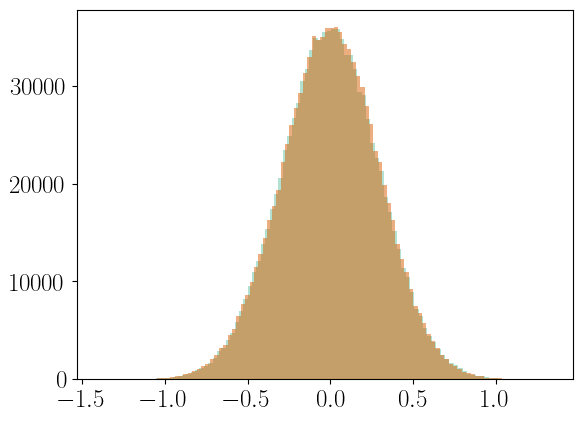

In [103]:
plt.hist(np.random.choice(mesh_true.flatten(), 1000_000), bins=100, alpha=0.5, label='true');
plt.hist(np.random.choice(init_nl.flatten(), 1000_000), bins=100, alpha=0.5, label='true');

## Example 2: quantify MCMC performance

### Number of eval per effective sample should converge. If so, that's a relevant metric.

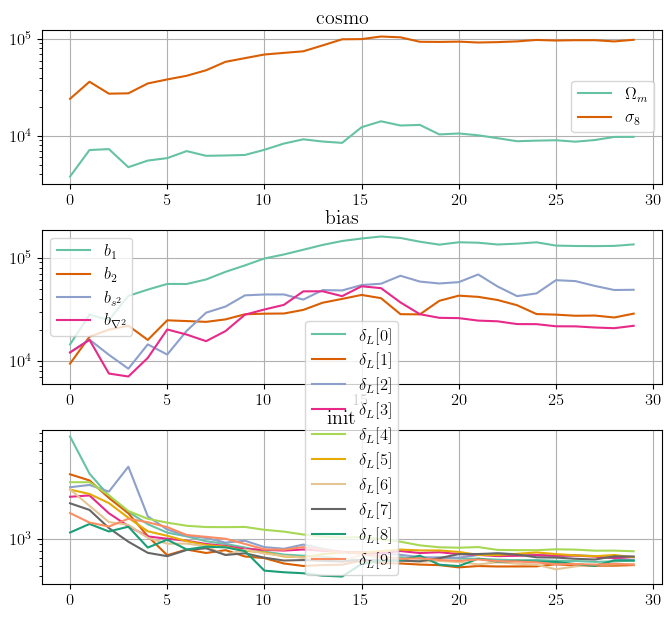

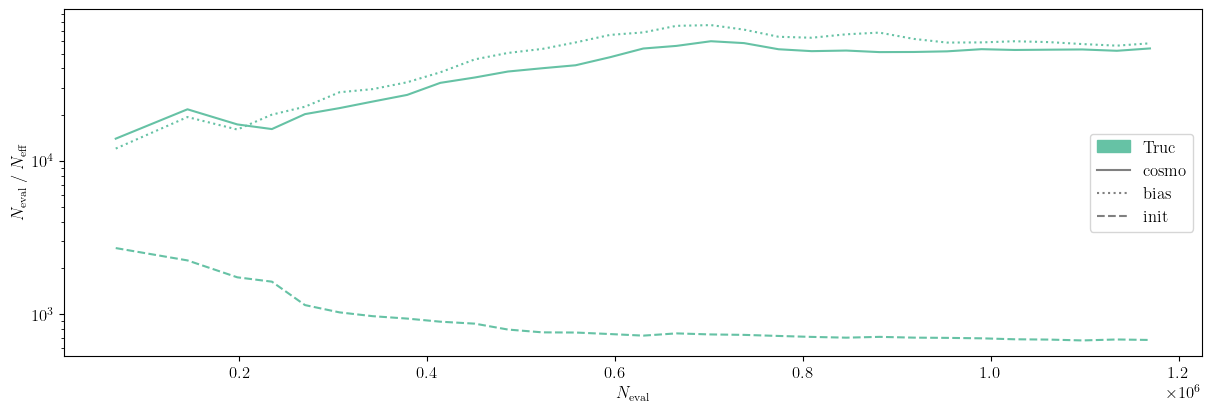

In [ ]:
plt.figure(figsize=(8, 6))
chains[['*~kptc']].flatten().cumtrans(Chains.eval_per_ess, 30).plot(names, 1, log=True)

labels = ['Truc']
metrics = []
cumess = chains[['*~kptc']].stackby(names).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn(metrics, labels):
    plt.figure(figsize=(12, 4), layout="constrained")
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn(metrics, labels)
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

## Comparison

{'Omega_m': (8, 1308), 'b1': (8, 1308), 'b2': (8, 1308), 'bn2': (8, 1308), 'bs2': (8, 1308), 'fNL': (8, 1308), 'init_mesh': (8, 1308, 10), 'kptc': ((8, 1308, 6), (8, 1308, 6), (8, 1308, 6), (8, 1308, 6)), 'logdensity': (8, 1308), 'mse_per_dim': (8, 1308), 'n_evals': (8, 1308), 'ngbar': (8, 1308), 'sigma8': (8, 1308)}

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           b2      0.42      0.86      0.40     -1.15      1.65    206.71      1.05
  mse_per_dim      0.00      0.00      0.00      0.00      0.00   1688.46      1.01
      n_evals    128.00      0.00    128.00    128.00    128.00       nan       nan
 init_mesh[0]     -0.00      0.13      0.00     -0.22      0.20   1059.59      1.00
 init_mesh[1]     -0.00      0.13     -0.00     -0.21      0.21   1055.96      1.00
 init_mesh[2]     -0.00      0.13     -0.00     -0.22      0.20    998.54      1.01
 init_mesh[3]      0.01      0.13      0.01     -0.21      0.21   1064.55      1.01
 init_me

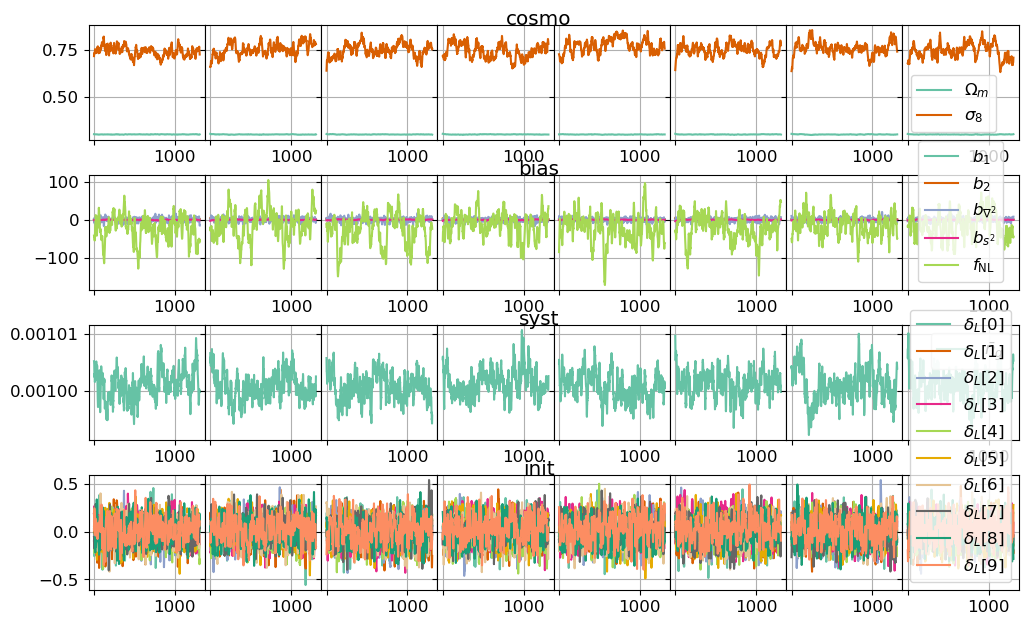

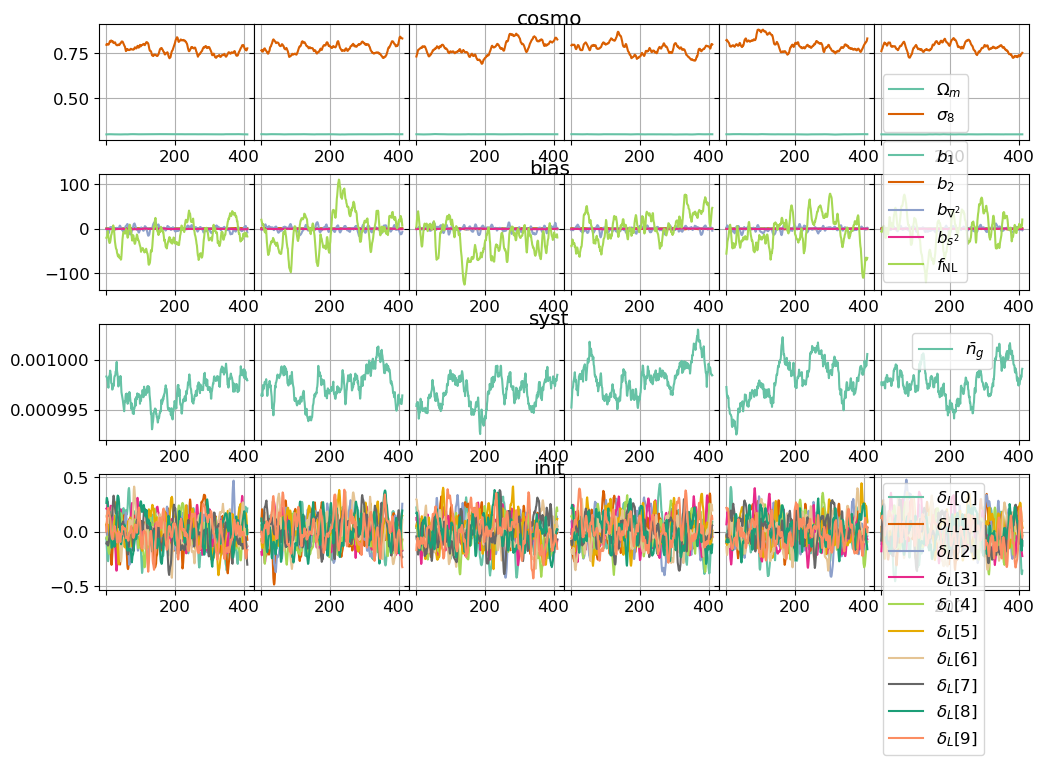

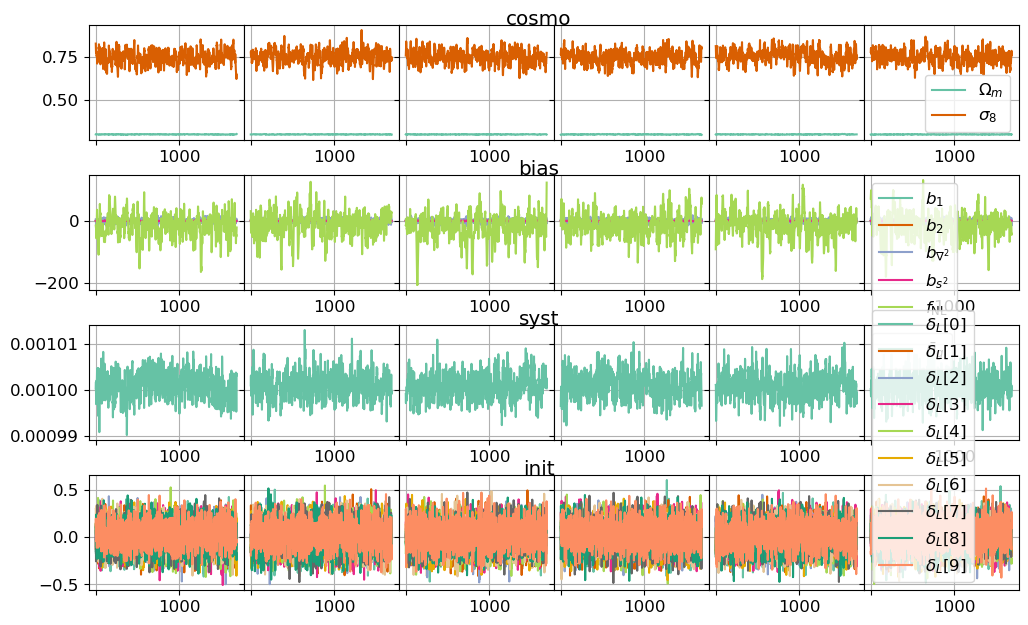

In [9]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme, SetDark2
theme(usetex=False, font_size=12)

ids = np.array([0,1,2])
# save_dir = Path("/feynman/home/dphp/hs276503/scratch/png")
save_dir = Path("/pscratch/sd/h/hsimfroy/png")
save_dirs = np.array([save_dir / s for s in [
                                            "lpt_32_fnl_0_lc_apauto", 
                                            "lpt_32_fnl_0_lc_apauto_flat", 
                                            "lpt_32_fnl_0_lc_apauto_nodec", 

                                            "lpt_32_fnl_0_lc_apauto", 
                                            "lpt_64_fnl_0_lc_appar",

                                            "lpt_64_fnl_p50", 
                                            "lpt_64_fnl_0", 
                                            "lpt_64_fnl_m50", 
                                            "lpt_fnl_64_kaiser_stat"]])[ids]
save_paths = np.array([save_dir / "test" for save_dir in save_dirs])
labels = np.array([
                    'LC, AP', 
                    'LC, AP, Flat', 
                    'LC, AP, NoDec',

                    'noLC, AP', 
                    'LC, AP', 
                    'LC, noAP', 
                    '$f_\\mathrm{NL} = -50$', 
                    '$f_\\mathrm{NL} = 0$', 
                    '$f_\\mathrm{NL} = +50$', 
                    '$f_\\mathrm{NL} = 0$'])[ids]

gdsamps = []
kptcs = []
names = ['cosmo','bias','syst','init']
# names = ['cosmo_','bias_','syst_','init_']

for sd, sp, lab in zip(save_dirs, save_paths, labels):
    model = FieldLevelModel.load(sd / "model.yaml")

    truth = dict(jnp.load(sd / 'truth.npz'))
    mesh_true = jnp.fft.irfftn(truth['init_mesh'])
    kpow_true = model.spectrum(mesh_true)
    delta_obs = model.count2delta(truth['obs'])
    kptc_obs = model.powtranscoh(mesh_true, delta_obs)

    obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','fNL','ngbar','init_mesh']
    obs = {k: truth[k] for k in obs}
    model.condition(obs, from_base=True)

    # transforms = [
    #             #   lambda x: x[:3],
    #             partial(Chains.thin, thinning=1),                     # thin the chains
    #             model.reparam_chains,                                 # reparametrize sample variables into base variables
    #             partial(model.powtranscoh_chains, mesh0=mesh_true),   # compute mesh statistics
    #             partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
    #             ]
    # chains = model.load_runs(sp, 2, 15, transforms=transforms, batch_ndim=2)
    print("Loading from", sp)
    chains = pload(sp + "_chains.p")
    chains = chains[:,100:]
    print(chains.shape)

    plt.figure(figsize=(12,6))
    chains[['*~kptc']].flatten().plot(names)
    chains[['*~kptc']].print_summary()

    gdsamp = chains[names[:-1]].to_getdist(lab)
    gdsamps.append(gdsamp)

    kptc = tree.map(jnp.concatenate, chains.pop('kptc', None))
    kptcs.append(kptc)


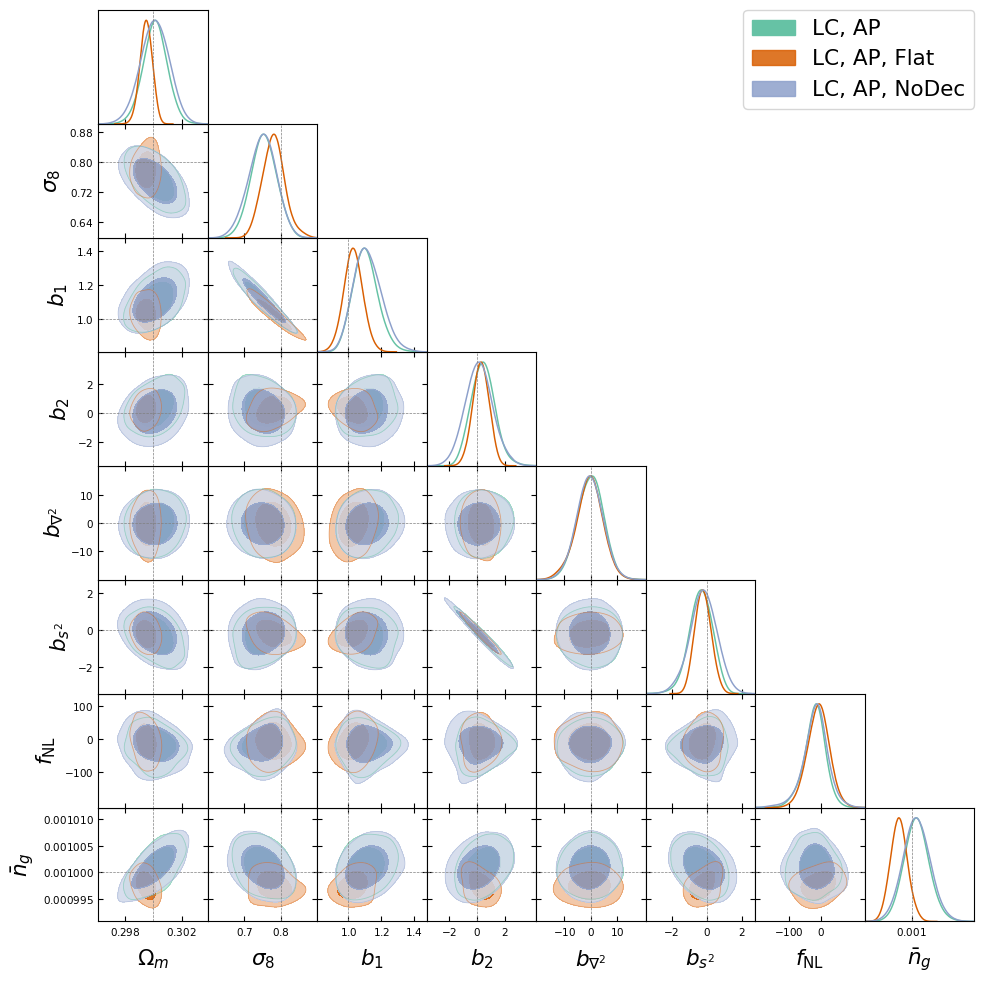

In [10]:
gdplt = plots.get_subplot_plotter(width_inch=10)
gdplt.settings.legend_fontsize = 20
gdplt.settings.axes_labelsize = 20
gdplt.settings.axes_fontsize = 12
gdplt.settings.figure_legend_frame = True
gdplt.settings.linewidth = 3
# gdplt.settings.num_plot_contours = 3
gdplt.triangle_plot(roots=gdsamps[:],
                    # params=['Omega_m','sigma8','b1','fNL'],
                    # params=['Omega_m','sigma8','b1','b2','bs2','bn2','fNL'],
                    # params=['fNL','sigma8','b1','b2','bs2','bn2'],
                # title_limit=1,
                filled=True, 
                markers={k:v for k,v in truth.items() if k not in ['fNL']},
                contour_colors=[SetDark2(i) for i in range(len(gdsamps))],
                legend_loc='upper right',
                )
# plt.savefig(save_dir / 'lpt_64_fnl_triangle.pdf', bbox_inches='tight')
# plt.savefig(save_dir / 'lpt_64_fnl_triangle.png', bbox_inches='tight')
# plt.savefig('lpt_64_fnl_triangle3.png', bbox_inches='tight')

## Animation

In [ ]:
import fitsio
from montecosmo.bricks import radecz2cart
from jax.scipy.spatial.transform import Rotation
import plotly.graph_objects as go


fits_path = Path("/home/nfs/bao/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
data = fitsio.read(fits_path, columns=['RA','DEC','Z'])
pos = radecz2cart(model.cosmo_fid, data)
pos = pos[np.random.choice(len(pos), 10_000, replace=False)]
pos_mesh = model.pos_mesh().reshape(-1,3)
frac_zero = lambda x: float((0 - np.min(x)) / (np.max(x) - np.min(x)))
padding = 0.2

fig = go.Figure()
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    legend=dict(xanchor="right", x=0.99, yanchor="top", y=0.9,) 
    # width=800, height=800,
    )

fig.add_scatter3d(x=[0], y=[0], z=[0], marker=dict(size=5, color='red', symbol='cross'), name='origin')

fig.add_scatter3d(
    x=pos[...,0], 
    y=pos[...,1], 
    z=pos[...,2], 
    mode='markers',
    marker=dict(size=2, color='royalblue', symbol='circle'),
    opacity=0.5,
    name='randoms',
    showlegend=True,
    visible="legendonly",
    )

fig.add_volume(
    x=pos_mesh[...,0],
    y=pos_mesh[...,1],
    z=pos_mesh[...,2],
    value=delta_obs.flatten(),
    opacity=1.,
    surface_count=5,
    name='observation',
    colorscale= [[0., '#2166ac'], [frac_zero(delta_obs), 'rgba(255, 255, 255, 0)'], [1., '#b2182b']],
    showlegend=True,
    hoverinfo='skip',
  )

fig.add_volume(
    x=pos_mesh[...,0],
    y=pos_mesh[...,1],
    z=pos_mesh[...,2],
    value=model.wind_mesh.flatten(),
    opacity=0.5,
    surface_count=5,
    colorscale= [[0., 'rgba(255, 255, 255, 0)'], [1., 'black']],
    name='window',
    showlegend=True,
    showscale=False,
    visible="legendonly",
    hoverinfo='skip',
  )

def plot_box(center, rotvec, shape, name=None, color='blue'):
    rect = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                    [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]])
    rot = Rotation.from_rotvec(rotvec)
    rect = rot.apply(shape * (rect - .5)) + center

    edges = [(0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
            (0, 4), (1, 5), (2, 6), (3, 7)]  # Vertical edges

    showlegend = True
    for edge in edges:
        fig.add_scatter3d(
            x=rect[edge, 0],
            y=rect[edge, 1],
            z=rect[edge, 2],
            mode='lines',
            line=dict(color=color, dash='solid'),
            legendgroup=name,
            showlegend=showlegend,
            name=name+f": {shape.prod() / 1e9:.1f} [Gpc/h]^3",
            opacity=0.5,
        )
        showlegend = False

plot_box(model.box_center, model.box_rotvec, model.box_shape / (1 + padding), name="box", color='darkblue')
# plot_box(model.box_center, model.box_rotvec, model.box_shape / (1 + padding), name="Data Box", color='darkblue')
# plot_box(model.box_center, model.box_rotvec, model.box_shape, name="Simu Box", color='darkblue')
fig.show()
fig.write_html("field.html", include_plotlyjs='cdn')

In [ ]:
from jax.scipy.spatial.transform import Rotation
import plotly.graph_objects as go

pos_mesh = model.pos_mesh().reshape(-1,3)
frac_zero = lambda x: float((0 - np.min(x)) / (np.max(x) - np.min(x)))

fig = go.Figure()
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    legend=dict(xanchor="right", x=0.99, yanchor="top", y=0.9,) 
    # width=800, height=800,
    )

fig.add_scatter3d(x=[0], y=[0], z=[0], marker=dict(size=5, color='red', symbol='cross'), name='origin')

fig.add_volume(
    x=pos_mesh[...,0],
    y=pos_mesh[...,1],
    z=pos_mesh[...,2],
    value=meshes.mean(0).flatten(),
    opacity=1.,
    surface_count=5,
    name='mean',
    colorscale=[[0., '#2166ac'], [frac_zero(meshes.mean(0)), 'rgba(255, 255, 255, 0)'], [1., '#b2182b']],
    showlegend=True,
    # visible="legendonly",
    hoverinfo='skip',
    )

fig.add_volume(
    x=pos_mesh[...,0],
    y=pos_mesh[...,1],
    z=pos_mesh[...,2],
    value=meshes.std(0).flatten(),
    opacity=.1,
    surface_count=5,
    name='std',
    colorscale=[[0., 'blue'], [1., 'rgba(255, 255, 255, 0)']],
    showlegend=True,
    visible="legendonly",
    hoverinfo='skip',
    )

# fig.add_volume(
#     x=pos_mesh[...,0],
#     y=pos_mesh[...,1],
#     z=pos_mesh[...,2],
#     value=model.wind_mesh.flatten(),
#     opacity=0.5,
#     surface_count=5,
#     colorscale=[[0., 'rgba(255, 255, 255, 0)'], [1., 'black']],
#     name='window',
#     showlegend=True,
#     showscale=False,
#     visible="legendonly",
#     hoverinfo='skip',
#     )

def plot_box(center, rotvec, shape, name=None, color='blue'):
    rect = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                    [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]])
    rot = Rotation.from_rotvec(rotvec)
    rect = rot.apply(shape * (rect - .5)) + center

    edges = [(0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
            (0, 4), (1, 5), (2, 6), (3, 7)]  # Vertical edges

    showlegend = True
    for edge in edges:
        fig.add_scatter3d(
            x=rect[edge, 0],
            y=rect[edge, 1],
            z=rect[edge, 2],
            mode='lines',
            line=dict(color=color, dash='solid'),
            legendgroup=name,
            showlegend=showlegend,
            name=name+f": {shape.prod() / 1e9:.1f} [Gpc/h]^3",
            opacity=0.5,
        )
        showlegend = False

plot_box(model.box_center, model.box_rotvec, model.box_shape, name="box", color='darkblue')
fig.show()
# fig.write_html("field.html", include_plotlyjs='cdn')